In [38]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/diplomatikh/GANMedicalImageGeneration

In [39]:
from utils import BreastCancerDataset, Visualizer
from models.train import train_GAN
from models.bases.generator_base import GeneratorBase
from models.simple.Discriminator import SimpleDiscriminator
import torch
import torch.nn as nn

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SLICED_FOLDER = '../sliced'
GENERATOR_PATH = '../step_by_step/generator.pth'
DISCRIMINATOR_PATH = '../step_by_step/discriminator.pth'
BATCHE_SIZE = 1
GEN_LEARNING_RATE =3e-4
DISC_LEARNING_RATE = 3e-4
REINITIALIZE_MODELS = False

In [41]:
visualizer = Visualizer()
dataset=BreastCancerDataset(sliced_folder=SLICED_FOLDER)
dataloader=  torch.utils.data.DataLoader(dataset, batch_size=BATCHE_SIZE, shuffle=True, num_workers=0)

In [42]:
class OutlineGenerator(GeneratorBase):
    def __init__(self,path,):
        super(OutlineGenerator, self).__init__()
        self.noise_shape = (2,8,8,2)
        self.path = path
        channels= 2
        self.outline =  nn.Sequential(
            *[self.upscale_block(channels) for _ in range(5)],
            nn.Sigmoid()
        )
    def upscale_block(self,channels):
        return nn.Sequential(
            nn.ConvTranspose3d(channels,channels,4,2,1),
            nn.LeakyReLU(0.1)
        )
    def forward(self, x):
        x = self.outline(x)
        return x

In [43]:
generator = OutlineGenerator(path=GENERATOR_PATH).to(device)
discriminator = SimpleDiscriminator(path=DISCRIMINATOR_PATH).to(device)



gen_optimizer = torch.optim.Adam(generator.parameters(), lr=GEN_LEARNING_RATE)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=DISC_LEARNING_RATE)
loss_function = nn.BCELoss()

In [ ]:
def generate_fixed_random_tensor(seed, size,device='cpu'):
    with torch.random.fork_rng():
        torch.manual_seed(seed)
        random_tensor = torch.rand(size,device=device)
    return random_tensor

CONSTANT_NOISE=  generate_fixed_random_tensor(0,generator.noise_shape,device=device)

In [44]:
if not REINITIALIZE_MODELS:
  try:
      generator.load_state_dict(torch.load(generator.path,map_location=torch.device(device)))
      discriminator.load_state_dict(torch.load(discriminator.path,map_location=torch.device(device)))
      print("Weights loaded")
  except:
      print("No weights found")
else:
    input('Are you sure you want to reinitialize?')


No weights found


In [1]:
def see_resutls(noise):
    output = generator(noise)
    img,mask = output[0],output[1]
    visualizer.visualize_distribution(img)
    visualizer.visualize_distribution(mask)
    visualizer(img,mask)

In [ ]:
see_resutls(CONSTANT_NOISE)

In [46]:
# train_GAN(generator,
#               discriminator,
#               dataloader,
#               gen_optim=gen_optimizer,
#               disc_optim=disc_optimizer,
#               loss_fn=loss_function,
#               epochs= 1,
#               device= device,
#               save_frequency=10,
#               verbose_frequency=10)

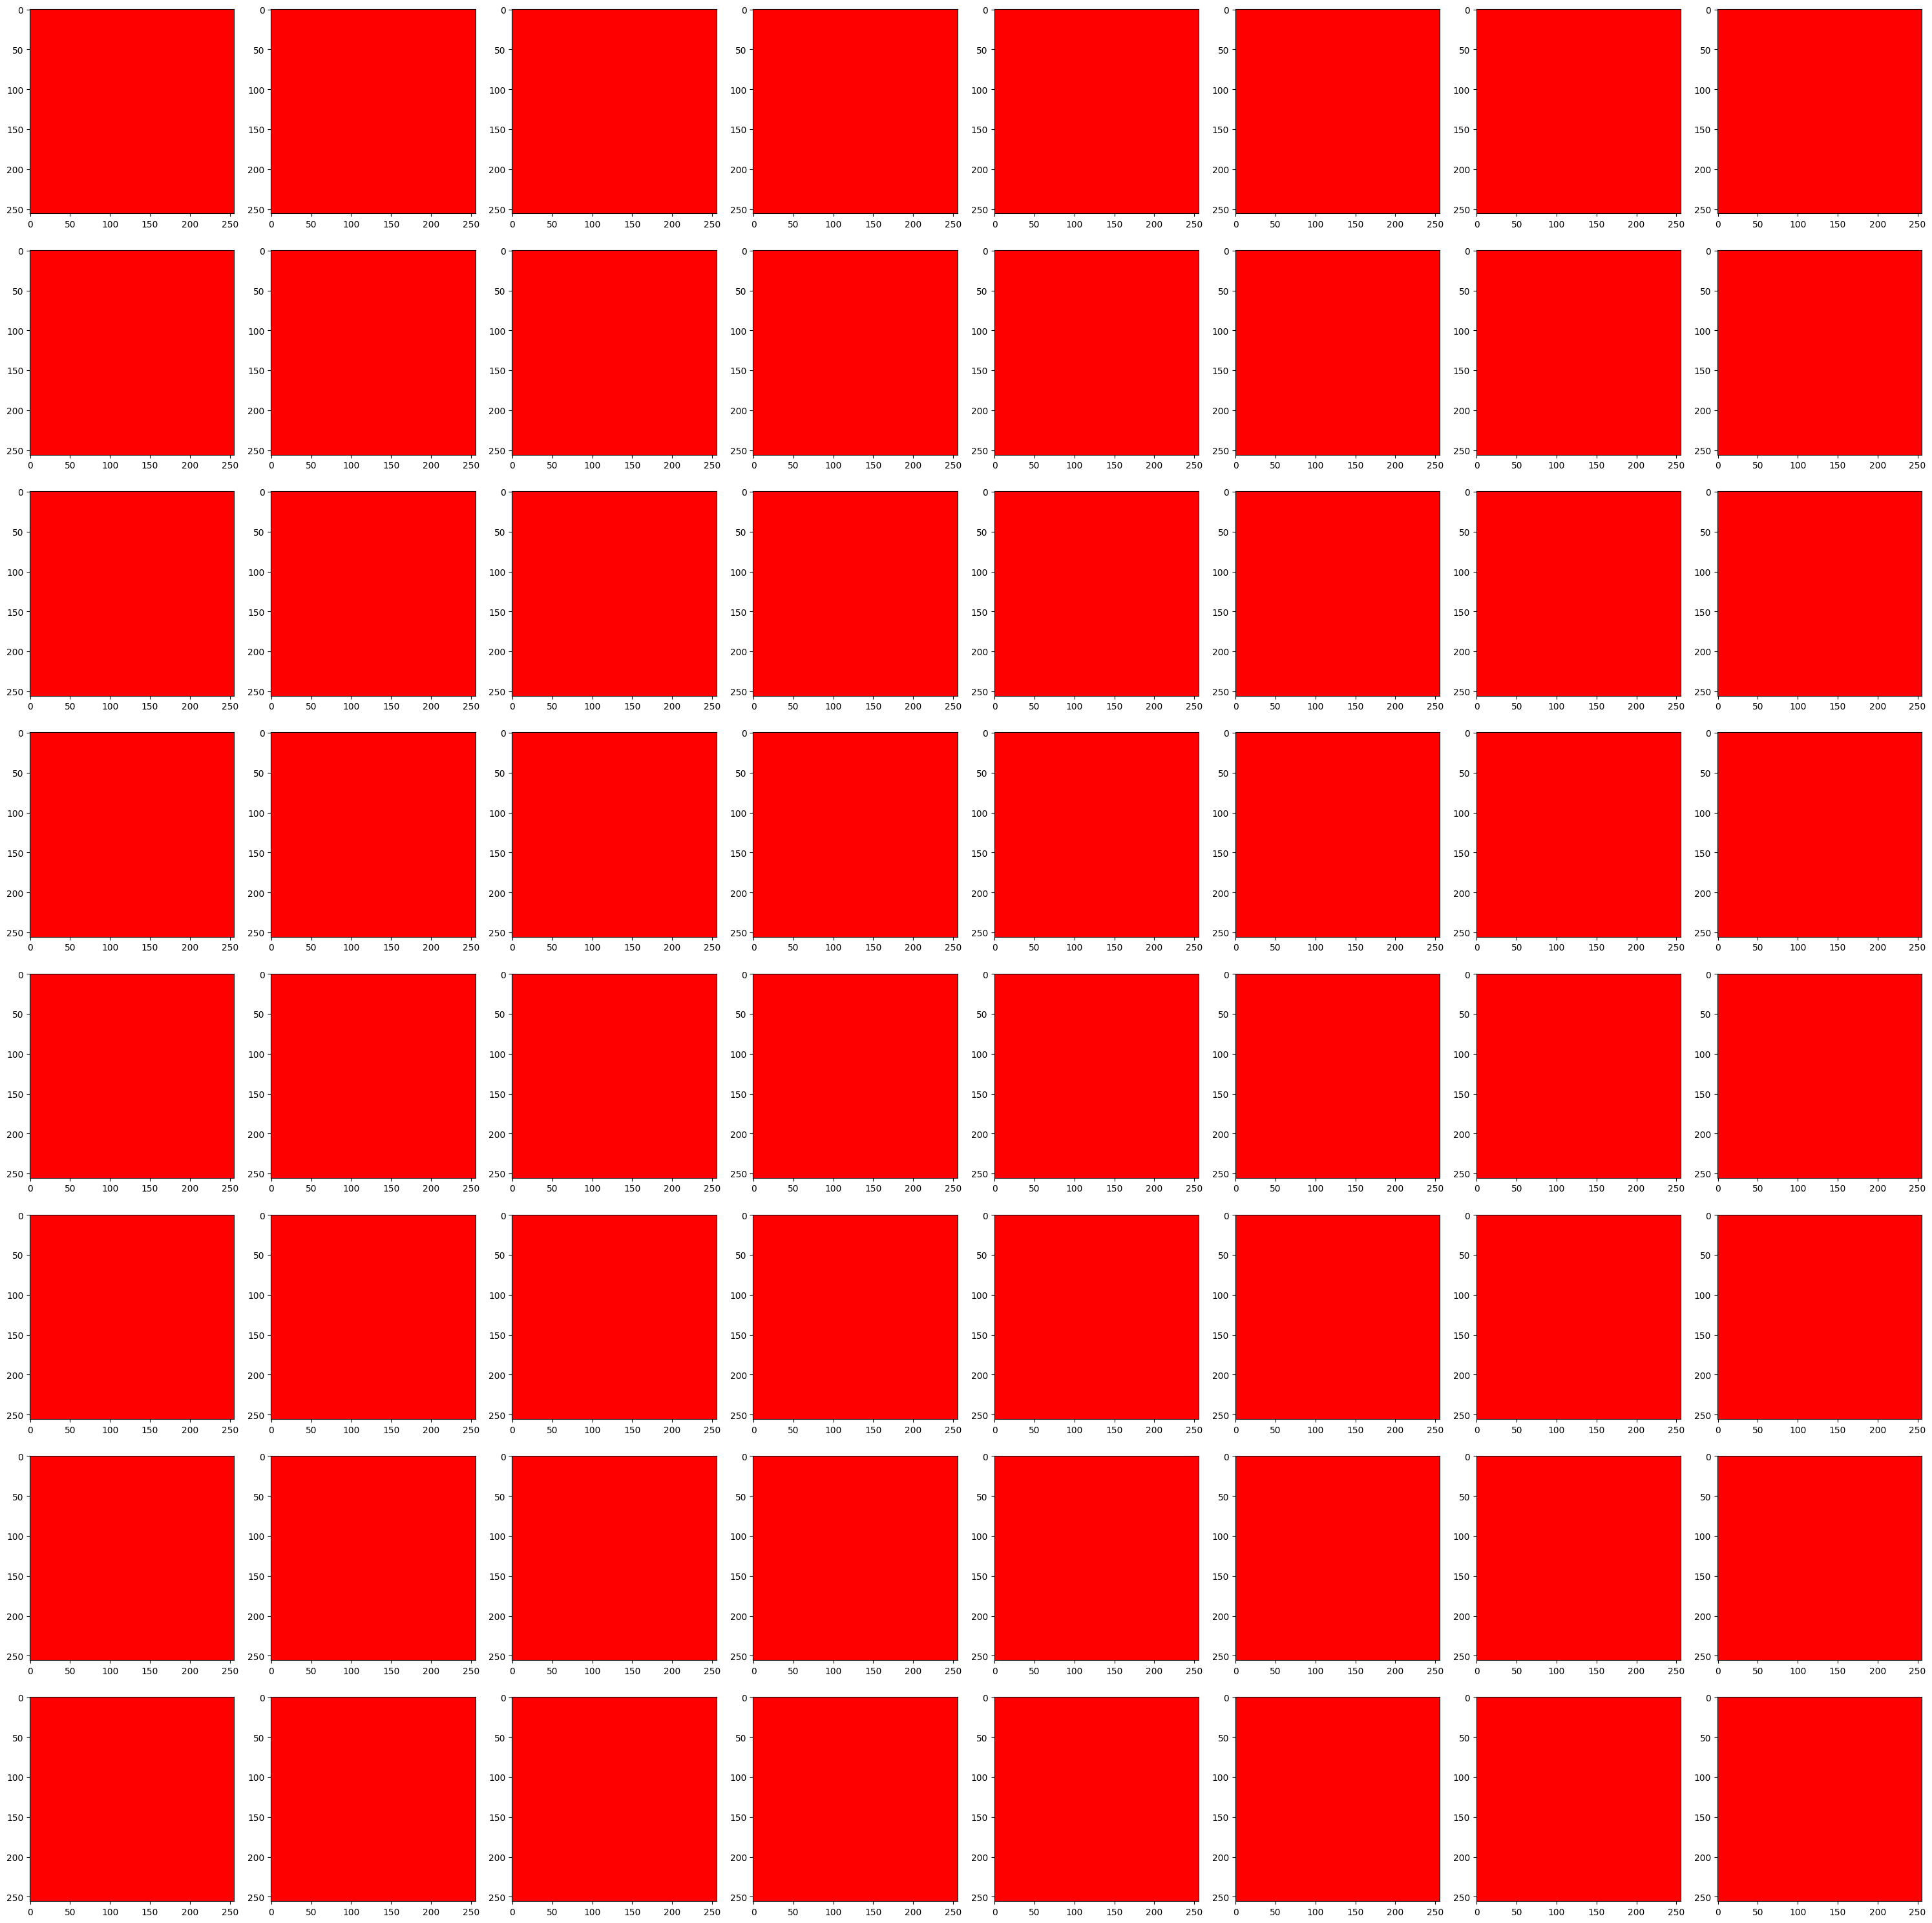

In [47]:
see_resutls(CONSTANT_NOISE)